# For Generating Many Endings for a Single Simulation

## Step 1
### Load nessecary modules

In [1]:
# Add python modules
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from copy import deepcopy
# Add parent directory for custom modules
from sys import path as sysPath
sysPath.append('../')
sysPath.append('../Machine_Score/')

# Load custom modules that simr has loaded
import main_SIMR as simr
gm = simr.gm
im = simr.im
SIM = simr.SIM
IMG = simr.IMG
ms = simr.ms
sa = simr.sa
dc = simr.ms.dc

simr.test()
gm.test()
im.test()
SIM.test()
IMG.test()
ms.test()
dc.test()
sa.test()
print('Done?')

SIMR: Hi!  You're in Matthew's main program for all things galaxy collisions
GM: Hi!  You're in Matthew's module for generally useful functions and classes
IM: Hi!  You're in Matthew's information module for SPAM
SIM: Hi!  You're in Matthew's main code for all things simulation.
IMG: Hi!  You're in Matthew's main code for all things image creation.
MS: Hi!  You're in Matthew's SIMR module for all things machine scoring images
DC: Hi!  You're in direct_image_compare.py
SA: Hi!  You're in Matthew's Main program for score analysis!
Done?


___
## Step 2
### Load Target Info class
Needed for loading the target image and running through models later.

In [2]:
tDir = '../targetDir/'
tDir = gm.validPath(tDir)

tInfo = im.target_info_class( targetDir = tDir, printAll=False)
if tInfo.status == False:
    print("WARNING: target info class bad")
else:
    print("Target Good!")

# Get run info class
rInfo = tInfo.getRunInfo( )
rInfo.printAll = True

if rInfo.status == False:
    print("WARNING")
else:
    print("Run '%s' Good!"%rInfo.get('run_id'))


Target Good!
Run 'run_0000' Good!


___
## 3. Example Many Endings Run

### 3.1 Test Old simulator

In [3]:
# Test old simulation
newName = 'dl-s2-1-test'
old_test = { newName : gm.deepcopy( tInfo.get('score_parameters')['dl-s2-0']) }
old_test[newName]['name'] = newName
old_test[newName]['simArg']['nPts'] = '500'
#old_test[newName]['simArg'].pop('type')
old_test[newName]['simArg']['name'] = newName
gm.pprint(old_test)

oldArgs = gm.inArgClass()
oldArgs.setArg( 'scoreParams', old_test )
oldArgs.setArg( 'runInfo', rInfo )
oldArgs.setArg( 'newSim', True )
oldArgs.setArg( 'zipSim', True )
oldArgs.setArg( 'overWrite', True )
oldArgs.setArg( 'printAll', True )

if False:
    simr.run_new_score( oldArgs, rInfo )

{'dl-s2-1-test': {'cmpArg': {'direct_compare_function': 'absolute_difference',
                             'targetName': 'dl-s2-0',
                             'targetType': 'target_image',
                             'type': 'direct_image_comparison'},
                  'comment': 'Default '
                             'Parameters '
                             'Deep-Learning '
                             'Experiment '
                             '2.',
                  'imgArg': {'blur': {'size': 13,
                                      'type': 'gaussian_blur',
                                      'weight': 1},
                             'comment': 'Image '
                                        'for '
                                        'Deep '
                                        'Learning '
                                        'Experiment '
                                        '2.',
                             'galaxy_centers': {'px': 84,
                 

### 3.2 Write Many Endings

In [4]:
# Import SIM variables as needed
spam_many_endings_exe = SIM.spam_many_endings_exe
maxN = SIM.maxN
getcwd = SIM.getcwd
chdir = SIM.chdir
system = SIM.system
rename = SIM.rename
path = SIM.path
remove = SIM.remove
ZipFile = SIM.ZipFile
sfName = SIM.sfName
ZIP_DEFLATED =  SIM.ZIP_DEFLATED

def many_endings( rInfo, simArg, cmdArg ):
    
    printBase = cmdArg.printBase
    printAll = cmdArg.printAll
        
    if printBase:
        print("\nSIM: many_endings:")
        im.tabprint("New Simulation Name: %s" % simArg['name'])
    
    # Grab needed variables and directories.
    model_data = rInfo.get('model_data', None)
    ptsDir = rInfo.get('ptsDir', None)
    tmpDir = rInfo.get('tmpDir', None)
    nPts = str( simArg.get('nPts',None) )
                
    if printAll:
        gm.tabprint("n particles: %s" % nPts)
        gm.tabprint("model_data: %s" % model_data)
        gm.tabprint("ptsDir: %s" % ptsDir)
        gm.tabprint("tmpDir: %s" % tmpDir)
    
    # Check for valid number of particles
    if nPts != None:
        # Check if using "k" abbreviation in num_particles
        if 'k' in nPts:
            kLoc = nPts.index('k')
            n = int( nPts[0:kLoc] ) * 1000
            nPts = n
        
        nPts = int( nPts )
        
        # Check if particle count is over max.
        if nPts > maxN:
            gm.eprint("\nWARNING: SIM: many_endings:")
            gm.etabprint("Number of points is greater than max")
            gm.etabprint("n particles: %s" % nPts)
            gm.etabprint("n max: %s" % maxN)
            return False
    # end if nPts
    
    # Check if needed info has been obtained
    if (model_data == None or ptsDir == None or tmpDir == None or nPts == None):
        
        gm.eprint("\nWARNING: SIM: many_endings:")
        gm.etabprint("A required argument was invalid")
        gm.etabprint("n particles: %s" % nPts)
        gm.etabprint("model_data: %s" % model_data)
        gm.etabprint("ptsDir: %s" % ptsDir)
        gm.etabprint("tmpDir: %s" % tmpDir)
        return False
    
    # Save current working directory and move to temp folder
    prevDir = getcwd()
    chdir( tmpDir )
    
    if printAll:
        im.tabprint(' Current Working Dir: %s' % getcwd() )
    
    # Call SPAM wrapper
    goodRun, retVal = many_endings_wrapper( nPts, model_data, printCmd = printAll )
    
    # Print results
    if not goodRun:
        gm.eprint("WARNING: SIM: many_endings")
        gm.etabprint("New simulation failed.  Error given: ")
        gm.eprint(retVal)
        return
    
    if goodRun and printAll:
        print("SIM: many_endings: Good simulation, value returned")
        print(retVal)
    
    # Generate file names and locations
    
    # Unique names
    fName = '%s_pts.101' % simArg['name']
    
    # Particle location created by SPAM.
    sfLoc = tmpDir + sfName
    
    # Unique Loc
    fLoc = tmpDir + fName
    
    # Rename SPAM temp particle files to prevent overwriting
    rename( sfLoc, fLoc )
    
    if printAll:
        im.tabprint("Particles Generated")
        im.tabprint("F: (%s) - %s" % ( path.isfile( fLoc ), fLoc ) )
    
    # Remove other files and outputs
    remove(tmpDir + "fort.21")
    remove(tmpDir + "fort.24")
    remove(tmpDir + "fort.50")
    remove(tmpDir + "gmon.out")
    remove(tmpDir + "gscript")
    
    # Check if saving particles files is required.
    if cmdArg.get("zipSim",False):
        
        zipName = '%s.zip' % simArg['name']
        
        if printAll: 
            im.tabprint("Zipping Files to: %s" % (ptsDir + zipName ) )
            
        # Auto closed on with exit
        with ZipFile( ptsDir + zipName, 'w') as myzip:
            myzip.write(fLoc, fName, compress_type=ZIP_DEFLATED)
    
    # Return to previous working directory to prevent potential errors elsewhere in code.
    chdir( prevDir )

# End Def many_endings

def many_endings_wrapper( nPts, model_data, printCmd ):
    sysCmd = '%s -m %d -n1 %d -n2 %d %s' % ( spam_many_endings_exe, 0, nPts, nPts, model_data) 

    if printCmd:
        print(sysCmd)
    
    # return False, "Not Implemented"
        
    try:
        retVal = system(sysCmd)        
        return True, retVal
            
    except Exception as e:
        return False, e

# End Def many_endings_wrapper




many_params = { 'dl-s2-1-many-test' : gm.deepcopy( tInfo.get('score_parameters')['dl-s2-0']) }
many_params['dl-s2-1-many-test']['name'] = 'dl-s2-1-many-test'
many_params['dl-s2-1-many-test']['simArg']['type'] = 'many_endings'
many_params['dl-s2-1-many-test']['simArg']['nPts'] = '500'
many_params['dl-s2-1-many-test']['simArg']['name'] = '500-many-endings'
#gm.pprint(many_params)

cmdArgs = gm.inArgClass()
cmdArgs.setArg( 'scoreParams', many_params )
cmdArgs.setArg( 'runInfo', rInfo )
cmdArgs.setArg( 'newSim', True )
cmdArgs.setArg( 'zipSim', True )
cmdArgs.setArg( 'overWrite', True )
cmdArgs.setArg( 'printAll', True )

# Function Copies to main_simulator.py
# SIM.many_endings = many_endings

if False: 
    simr.run_new_score( cmdArgs, rInfo )




### 3.3 Verify zip file was created

In [5]:
print( 'Temp dir: ', os.listdir( rInfo.get('tmpDir') ) )
print( 'Pts dir: ', os.listdir( rInfo.get('ptsDir') ) )


Temp dir:  []
Pts dir:  ['1k.zip', 'dl-s2-1-test.zip', 'orbit.txt', '4k-many-endings.zip', '4k.zip', '500-many-endings.zip', '10k.zip']


___
## Step 4 Read Many Ending Particles

### Create Run Info Class read many endings

In [6]:
    def readManyEndingsParticles( self, ptsName ):

        
        if self.printAll:
            print("IM.run_info_class.readManyEndingsParticles:")
            gm.tabprint('pts name: %s' % ptsName )
        
        # See if particle files are in temp folder unzipped
        iLoc, fLoc = self.findPtsLoc( ptsName = ptsName )

        # If found, read and return
        if fLoc != None:
            pts = pd.read_csv( fLoc, header=None, delim_whitespace=True ).values
            return pts
        
        
        # Else need to unzip a file
        ptsZipLoc = self.findZippedPtsLoc( ptsName = ptsName )

        if self.printAll: tabprint("Loading points from file: %s"%ptsZipLoc)

        if ptsZipLoc == None:
            gm.eprint("WARNING: IM.run_info_class.readManyEndingsParticles:")
            gm.etabprint("zipped points not found: %s"%ptsZipLoc)
            return None, None


        from zipfile import ZipFile

        
        zipLoc = self.findPtsLoc( ptsName )        
        if zipLoc == None:
            return None

        # Check if zip files need rezipping
        self.delTmp()
        rezip = False

        with ZipFile( ptsZipLoc ) as zip:

            for zip_info in zip.infolist():

                if zip_info.filename[-1] == '/':
                    continue
                if len( zip_info.filename.split('/') ) > 1:
                    rezip = True

                zip_info.filename = path.basename( zip_info.filename)
                zip.extract(zip_info, self.tmpDir)

        if rezip:
            from os import remove
            remove(zipLoc)

            with ZipFile( zipLoc, 'w' ) as zip:
                for f in listdir( self.tmpDir ):
                    fLoc = self.tmpDir + f
                    zip.write( fLoc, path.basename(fLoc) )

        files = listdir( self.tmpDir )
        pts = None

        for f in files:
            fLoc = self.tmpDir + f

            if '.101' in f:
                pts = pd.read_csv( fLoc, header=None, delim_whitespace=True ).values
        
        return pts

    #rInfo.readManyEndingsParticles = readManyEndingsParticles

    from os import listdir
    import pandas as pd


    #pts = readManyEndingsParticles( rInfo, '500-many-endings' )

    # readManyEndingsParticles has been copied to run info class.
    if False:
        pts = rInfo.readManyEndingsParticles( '500-many-endings' )
        print( type( pts ) )
        print( pts.shape )

### 4.2 Test Old getParticles
Add simulation types


In [7]:
# Test old simulation
newName = 'dl-s2-1-test'
old_test = { newName : gm.deepcopy( tInfo.get('score_parameters')['dl-s2-0']) }
old_test[newName]['name'] = newName
old_test[newName]['simArg']['nPts'] = '500'
#old_test[newName]['simArg'].pop('type')
old_test[newName]['simArg']['name'] = newName
old_test[newName]['imgArg']['name'] = newName

oldArgs = gm.inArgClass()
oldArgs.setArg( 'scoreParams', old_test )
oldArgs.setArg( 'runInfo', rInfo )
oldArgs.setArg( 'overWrite', True )
oldArgs.setArg( 'newImage', True )

oldArgs.setArg( 'printAll', True )


if True:
    gm.pprint(old_test)
    simr.IMG.main_img_run( rInfo, oldArgs )

    print( 'Model Images: ', os.listdir( rInfo.get('imgDir') ) )
    print( 'Init  Images: ', os.listdir( rInfo.get('miscDir') ) )
    


{'dl-s2-1-test': {'cmpArg': {'direct_compare_function': 'absolute_difference',
                             'targetName': 'dl-s2-0',
                             'targetType': 'target_image',
                             'type': 'direct_image_comparison'},
                  'comment': 'Default '
                             'Parameters '
                             'Deep-Learning '
                             'Experiment '
                             '2.',
                  'imgArg': {'blur': {'size': 13,
                                      'type': 'gaussian_blur',
                                      'weight': 1},
                             'comment': 'Image '
                                        'for '
                                        'Deep '
                                        'Learning '
                                        'Experiment '
                                        '2.',
                             'galaxy_centers': {'px': 84,
                 

In [10]:


def getManyParticles( rInfo, simName, printAll = False ):

    if printAll: 
        print("IMG: getManyParticles: ")
        gm.tabprint( "simArg: %s" % type(simName ) )

    # Check if rInfo has pts dictionary
    if rInfo.get('pts',None) == None:
        rInfo.pts = {}
    
    # Check if files are loaded in run info class
    pts = rInfo.pts.get(simName,None)

    # Return points if  found
    if type(pts) != type(None):
        return pts

    raw_pts = rInfo.readManyEndingsParticles( simName )

    if type(raw_pts) == type(None):
        gm.eprint("ERROR: IMG.getManyParticles:")
        gm.etabprint("Could not read particles: %s"%simName)
        return None

    # Count images by modding by 100, There is an extra point per 2nd galaxy center
    nImgs = raw_pts.shape[0] % 100

    # Count particles per galaxy by dividing by NImgs
    nptsImg = int( ( raw_pts.shape[0] - nImgs) / (nImgs) ) + 1

    if printAll: 
        gm.tabprint("Read Many Particles: %s"%str(raw_pts.shape))
        gm.tabprint("Number of images: %s"%nImgs)
        gm.tabprint("Number of particles per image: %s"%nptsImg)

    # Create list of images
    ptsList = []

    for i in range(nImgs):

        iPts = particle_class( None, raw_pts[i*nptsImg:i*nptsImg+nptsImg] )

        validPts = type(getattr(iPts,'g1f')) != type(None)

        if printAll:  gm.tabprint("valid Points: %s"%validPts)
        
        if validPts: 
            if printAll: gm.tabprint("Points shape: %s"%str(getattr(iPts,'g1f').shape))
            ptsList.append( iPts )

    if len(ptsList) == 0:
        gm.eprint("ERROR: IMG.getManyParticles:")
        gm.etabprint("No valid particles found: %s"%simName)
        return None
        
    # Add List to runInfo
    rInfo.pts[simName] = ptsList

    return ptsList

# End getManyParticles


def create_many_endings_images( rInfo, sParam, overwrite=False, printAll = False, ):
    
    if printAll: 
        print("IMG: create_many_endings_images:")
        gm.tabprint('runId: %s'%rInfo.get('run_id'))
        gm.tabprint('score: %s'%sParam.get('name'))
        
    # Add place to keep points and images in memory
    if rInfo.get('img',None) == None:
        rInfo.img = {}
        
    if rInfo.get('pts',None) == None:
        rInfo.pts = {}
    
    # Grab idenitfying names
    imgName = sParam['imgArg'].get('name',None)
    simName = sParam['simArg'].get('name',None)

    # If Image is already created
    if imgName in rInfo.img and not overwrite:
        if printAll: im.tabprint("Image already in runInfo: %s"%imgName)
        return rInfo.img[imgName]
    
    # Check if image exists on disk
    if not overwrite:
        imgLoc = rInfo.getModelImage( imgName, imgType='many_endings' )
        if type(imgLoc) != type(None):
            if printAll: im.tabprint("Image already exists: %s"%imgName)
            return rInfo.readImage( imgName, imgType='many_endings')

    # If image does not exist, read Particles
    if printAll: im.tabprint("Creating image: %s"%imgName)

    # Get particles
    ptsList = getManyParticles( rInfo, simName, printAll=printAll )

    # If no particles found, print error and return
    if type(ptsList) == type(None):
        gm.eprint("ERROR: IMG.create_many_endings_images:")
        gm.etabprint("Could not find particles: %s"%simName)
        return

    # Get args
    imgArg = sParam['imgArg']

    # Create array to contain images
    manyImg = np.zeros( ( len(ptsList), imgArg['image_size']['height'], imgArg['image_size']['width'] )  )
    print( 'manyImg shape: ', manyImg.shape )
    
    for i, pts in enumerate(ptsList):

        # Add particles to image
        mImg = pts2image( pts,  imgArg )
        mImg = blurImg( mImg, imgArg )
        mImg = normImg( mImg, imgArg )

        # Use image as float32 type for scoring
        if mImg.dtype == np.uint8:
            mImg = gm.uint8_to_float32( mImg )
            rInfo.img[imgName] = mImg

        # Check for valid image
        if type(mImg) == type(None):
            gm.eprint("ERROR: IMG.create_many_endings_images:")
            gm.etabprint("Could not create image: %s"%imgName)
            return
        
        manyImg[i] = mImg
    
    # Save image to runInfo
    rInfo.img[imgName] = manyImg
    
    # Check if manyImg is all zeros
    if np.sum(manyImg) == 0:
        gm.eprint("ERROR: IMG.create_many_endings_images:")
        gm.etabprint("No Image was created: %s"%imgName)
        return
    
    # Get new image from rInfo
    
    rInfo.saveImage( imgName, manyImg, imgType = 'many_endings' )
    

# End create_many_endings_images


# Function Copies to main_simulator.py
# SIM.many_endings = many_endings

if True: 

    # Import local functions from SIM
    # pts2image = simr.IMG.pts2image
    # particle_class = simr.IMG.particle_class
    # blurImg = simr.IMG.blurImg
    # normImg = simr.IMG.normImg

    manyName = 'dl-s2-1-many-test-2'
    many_params = { manyName : gm.deepcopy( tInfo.get('score_parameters')['dl-s2-0']) }
    many_params[manyName]['name'] = manyName
    many_params[manyName]['simArg']['type'] = 'many_endings'
    many_params[manyName]['imgArg']['type'] = 'many_endings'
    many_params[manyName]['simArg']['nPts'] = '4k'
    many_params[manyName]['simArg']['name'] = '4k-many-endings'
    many_params[manyName]['imgArg']['name'] = manyName

    cmdArgs = gm.inArgClass()
    cmdArgs.setArg( 'scoreParams', many_params )
    cmdArgs.setArg( 'runInfo', rInfo )
    # cmdArgs.setArg( 'newSim', True )
    # cmdArgs.setArg( 'zipSim', True )
    cmdArgs.setArg( 'newImage', True )
    cmdArgs.setArg( 'overWrite', True )
    cmdArgs.setArg( 'printAll', True )

    # Copy over
    # IMG.create_many_endings_images = create_many_endings_images
    # getManyParticles = IMG.getManyParticles
    gm.pprint(many_params)
    
    simr.run_new_score( cmdArgs, rInfo )


{'dl-s2-1-many-test-2': {'cmpArg': {'direct_compare_function': 'absolute_difference',
                                    'targetName': 'dl-s2-0',
                                    'targetType': 'target_image',
                                    'type': 'direct_image_comparison'},
                         'comment': 'Default '
                                    'Parameters '
                                    'Deep-Learning '
                                    'Experiment '
                                    '2.',
                         'imgArg': {'blur': {'size': 13,
                                             'type': 'gaussian_blur',
                                             'weight': 1},
                                    'comment': 'Image '
                                               'for '
                                               'Deep '
                                               'Learning '
                                               'Experiment '
  

In [9]:
# Save new many_endings example param
if True:
    
    pDir = '../param/'
    print( os.listdir( pDir))
    gm.saveJson( manyName, pDir + rInfo.img[manyName] + '.json', pretty=True )

['zoo_test_3.json', 'cmd_args_test.json', 'graham_ms.json', 'exp_0_ms.json', 'exp_3_ga.json', 'dl-s1-0.json', 'sim2k_zoo100x100_mic_score.json', 'norm_chime_1.json', 'exp_2_ms.json', 'param_zoo_test.json', 'dl-test-s2-0.json', 'exp_2_cmd.json', 'norm_wndchrm_all_test.json', 'chime_test.json', 'zoo_test.json', 'nn_score_param_base.json', 'exp_2_ga.json', 'zoo_blank.json', 'exp_4_ms.json', 'exp_4_ga.json', 'chime_group_1.json', 'nn_train_base.json', 'init_ga_param.json', 'exp_0_ga.json', 'ga_param_test.json', 'start_param.json', 'zoo_base.json', '.ipynb_checkpoints', 'test_param.json', 'dl-s2-0.json', 'chime_group_0.json', 'dl-s1-seed.json', 'exp_base.json', 'mask_roi_blank.json']


NameError: name 'manyName' is not defined

In [9]:
print( 'modelImages', os.listdir( rInfo.get('imgDir')))

modelImages ['dl-s1-0_model.png', 'dl-s2-0_model.png', 'dl-s2-1-test_model.png', '.ipynb_checkpoints', 'dl-s2-1-many-test-2.npz']


IM.run_info_class.getModelImage:
	 - img name: dl-s2-1-many-test-2
	 - img type: many_endings
manyImg shape:  (11, 128, 128)


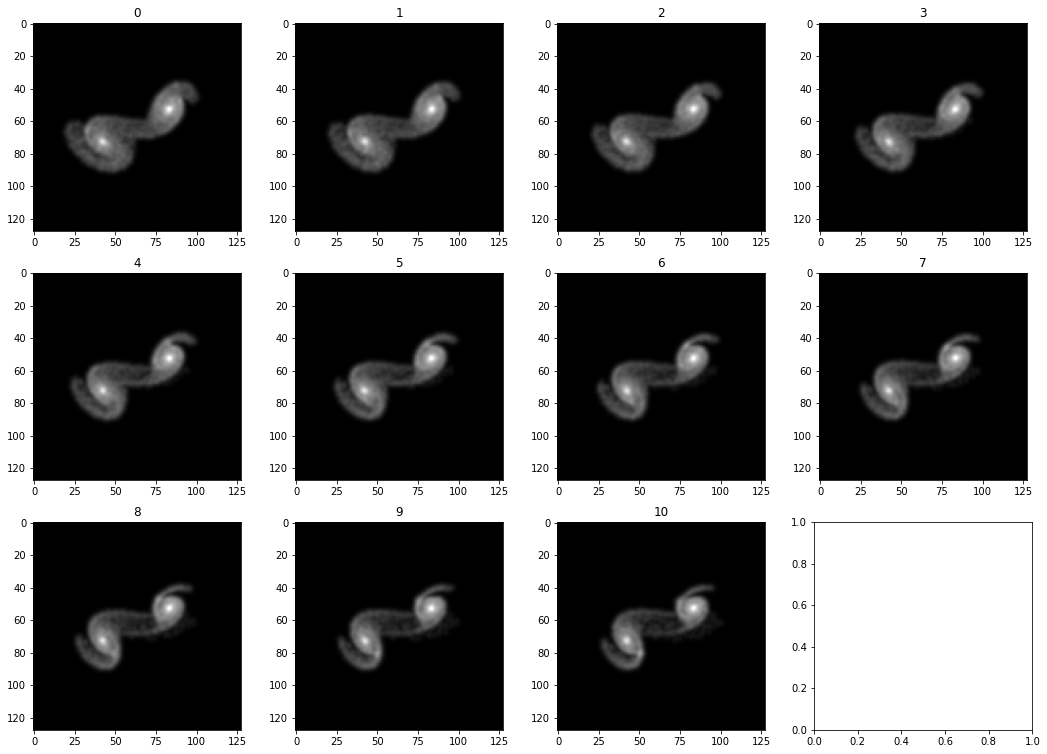

In [11]:
rInfo.printAll = True
manyImg = rInfo.getModelImage( 'dl-s2-1-many-test-2', imgType='many_endings' )
print( 'manyImg shape: ', manyImg.shape )

imgList = []
for i in range( manyImg.shape[0] ):
    imgList.append( manyImg[i] )

gm.showImgList( imgList, size=18 )